## POBOLJŠANJE REZULTATA ČLANKA

In [32]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [33]:
data = pd.read_csv("combined_data.csv")
print(data.shape)
print(data.columns.values)
data

(608, 10)
['ID' 'M/F' 'Age' 'Educ' 'SES' 'MMSE' 'CDR' 'eTIV' 'nWBV' 'ASF']


,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,0,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,0,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,0,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0010_MR1,1,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,OAS1_0011_MR1,0,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
603,OAS2_0185,1,82,3.0,1.0,28.0,0.5,1693,0.694,1.037
604,OAS2_0185,1,86,3.0,1.0,26.0,0.5,1688,0.675,1.040
605,OAS2_0186,0,61,3.0,2.0,30.0,0.0,1319,0.801,1.331
606,OAS2_0186,0,63,3.0,2.0,30.0,0.0,1327,0.796,1.323


In [34]:
def demented(row):
    if row.CDR >= 0.5:
        return 1
    else:
        return 0


In [35]:
data.loc[:,'Demention'] = data.apply(lambda row: demented(row), axis=1) #izlazna varijabla

**POVEĆANJE PODATKOVNOG SKUPA**

Povećali smo podatkovni skup longitudinalne studije s *373* podataka na *608* dodavši subjekte iz unakrsne studije. Subjekte koji su imali nedostajuće vrijednosti za više značajki koje su bitne za predikciju (SES, MMSE,Educ) nismo dodali kako bi se klasifikatori radili na više stvarnih podataka, a ne s interpolacijama. 

38 nedostajućih vrijednosti za značajku SES subjekata interpolirali smo medijanom te značajke na kombiniranom skupu. Značajka MMSE je interpolirana na temelju razine obrazovanja: ovisno kojoj razini subjekt pripada pridjeljena mu je srednja vrijednost značajke MMSE za tu razinu obrazovanja.

**OPASNOST OD CURENJA PODATKA U LONGITUDINALNOJ STUDIJI**

U članku su slučajno podjelili podatkovni skup na skup za treniranje i skup za testiranje u omjeru 70:30. Budući da se radi o longitudinalnoj studiji, treba pripaziti da se isti subjekt pojavi i u skupu za treniranje i u skupu za testiranje. Kako bi izbjegli curenje podataka (engl. data leakage) podjelu skupa na treniranje i testiranje radimo po identifikacijskom broju subjekta. 

In [36]:
subjects = data["ID"].unique()
subjects_train, subjects_test = train_test_split(subjects, test_size=0.31, random_state = 8) #70% od 608 je 425.6
train_df = data[data["ID"].isin(subjects_train)]
test_df = data[data["ID"].isin(subjects_test)]
print(train_df.shape, test_df.shape)
train_Y = train_df.loc[:, 'Demention']
train_X = train_df.loc[:,data.columns.isin(["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
test_Y = test_df.loc[:, 'Demention']
test_X = test_df.loc[:,data.columns.isin(["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]

(426, 11) (182, 11)


**TRENIRANJE MODELA KORIŠTENIH U ČLANKU**

U članku su isprobali sljedeće klasifikatore: stablo odluka, slučajne šume, XGBoost, SVM, soft voting i hard voting klasifikator.
Optimirali smo hiperparametre tih modela (pomoću 5-fold unakrsne provjere) i trenirali ih na proširenom skupu. Pri testiranju i unakrsnoj provjeri (10-fold cross validation) potrebno je pripaziti  na potencijalno curenje informacija.

**STABLO ODLUKA**

In [37]:
max_depth = [i for i in range(1,8)]
max_features = [i for i in range(1,8)]
accuracy = 0
best_combination = [max_depth[0],max_features[0]]

groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits= 5)

for d in max_depth:
    for f in max_features:
        scores_acc = []
        for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

            train = train_df[train_df["ID"].isin(groups[train_index])]
            test = train_df[train_df["ID"].isin(groups[test_index])]
    
            train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
            train_y1 = train.loc[:,"Demention"]

            test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
            test_y1 = test.loc[:,"Demention"]
    

    
            clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = d, max_features = f)
            clf.fit(train_x1,train_y1)
    
            dt_predictions = clf.predict(test_x1)
 
            dt_accuracy = accuracy_score(test_y1,dt_predictions)
            
            scores_acc.append(dt_accuracy)
        if (np.array(scores_acc).mean())> accuracy:
            accuracy = np.array(scores_acc).mean()
            best_combination = [d,f]
        #print(d,f,np.array(scores_acc).mean())
        
print(f"Najbolja kombinacija hiperparametara je: maxdepth: {best_combination[0]} i max_features: {best_combination[1]}")

Najbolja kombinacija hiperparametara je: maxdepth: 3 i max_features: 3


Uvidom u točnost klasifikacije po rešetci hiperparametara (maxdepth-dubina stabla i max_features-broj značajci koje se razmatraju po grananju) dobiva se najbolja točnost za dubinu 1 i broj značajki 7 (sve značajke). Ista točnost se dobiva i za dubinu 2 i broj značajki 4 - odlučili smo se za te paramtere kako bi se izbjegla prenaučenost, odnosno podnaučenost, modela.

In [38]:
groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits= 10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):
    
    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]

    test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]
    

    
    clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2, max_features = 4, random_state = 42)
    clf.fit(train_x1,train_y1)
    
    dt_predictions = clf.predict(test_x1)
 
    dt_accuracy = accuracy_score(test_y1,dt_predictions)
    dt_precision = precision_score(test_y1,dt_predictions)
    dt_recall = recall_score(test_y1,dt_predictions)
    dt_f1 = f1_score(test_y1,dt_predictions)
    scores_accuracy.append(dt_accuracy)
    scores_precision.append(dt_precision)
    scores_recall.append(dt_recall)
    scores_f1.append(dt_f1)

average_accuracy_dt = (np.array(scores_accuracy)).mean()
average_precision_dt = (np.array(scores_precision)).mean()
average_recall_dt = (np.array(scores_recall)).mean()
average_f1_dt = (np.array(scores_f1)).mean()

print("MODEL STABLA ODLUKA - 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_dt:.3f}")
print(f"Prosječna točnost (precision): {average_precision_dt:.3f}")
print(f"Prosječna točnost (recall): {average_recall_dt:.3f}")
print(f"Prosječna točnost (f1): {average_f1_dt:.3f}")


MODEL STABLA ODLUKA - 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.810
Prosječna točnost (precision): 0.891
Prosječna točnost (recall): 0.647
Prosječna točnost (f1): 0.743


**SLUČAJNE ŠUME**

Provjerili smo koliko je optimalno stabala udružiti u ansambl slučajnih šuma: pokazalo se da je dovoljno uključiti 50 stabala- model nije presložen, a točnost je zadovoljavajuća.

In [39]:
number_of_trees = [1,25,50,75,100,125,150,175,200,225]
for i in number_of_trees:
    #print("broj stabala: " + str(i))
    clf = RandomForestClassifier(criterion = "entropy", n_estimators = i)
    
    scores = cross_val_score(clf, train_X, train_Y, cv=5)
    score = scores.mean()
    #print(f"točnost: {score:.3f}")

In [40]:
max_depth = [i for i in range(1,8)]
max_features = [i for i in range(1,8)]
accuracy = 0
best_combination = [max_depth[0],max_features[0]]

groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits= 5)

for d in max_depth:
    for f in max_features:
        scores_acc = []
        for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):
            
            train = train_df[train_df["ID"].isin(groups[train_index])]
            test = train_df[train_df["ID"].isin(groups[test_index])]
    
            train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
            train_y1 = train.loc[:,"Demention"]

            test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
            test_y1 = test.loc[:,"Demention"]

   
    
            clf = RandomForestClassifier(criterion = "entropy", n_estimators = 50, max_depth = d, max_features = f)
            clf.fit(train_x1,train_y1)
    
            dt_predictions = clf.predict(test_x1)
            dt_accuracy = accuracy_score(test_y1,dt_predictions)
            scores_acc.append(dt_accuracy)
        if (np.array(scores_acc).mean())> accuracy:
            accuracy = np.array(scores_acc).mean()
            best_combination = [d,f]
        print(d,f,np.array(scores_acc).mean())
        
print(f"Najbolja kombinacija hiperparametara je: maxdepth: {best_combination[0]} i max_features: {best_combination[1]}")

1 1 0.72328317373461
1 2 0.8123666210670315
1 3 0.8241313269493844
1 4 0.8241313269493844
1 5 0.8241313269493844
1 6 0.8241313269493844
1 7 0.8241313269493844
2 1 0.7935978112175103
2 2 0.826484268125855
2 3 0.8241313269493844
2 4 0.8241313269493844
2 5 0.8241313269493844
2 6 0.8241313269493844
2 7 0.8241313269493844
3 1 0.7982489740082079
3 2 0.8170725034199726
3 3 0.8194254445964433
3 4 0.8241313269493844
3 5 0.8241313269493844
3 6 0.8217783857729138
3 7 0.8217783857729138
4 1 0.802954856361149
4 2 0.8076607387140904
4 3 0.8194254445964433
4 4 0.8241313269493844
4 5 0.8217783857729138
4 6 0.810013679890561
4 7 0.8123666210670315
5 1 0.8005471956224349
5 2 0.8146922024623802
5 3 0.8217783857729138
5 4 0.8076607387140904
5 5 0.8147195622435021
5 6 0.8076607387140904
5 7 0.8170725034199726
6 1 0.7958413132694939
6 2 0.8099863201094392
6 3 0.8123392612859097
6 4 0.8146648426812586
6 5 0.8193980848153215
6 6 0.8193707250341997
6 7 0.8146648426812586
7 1 0.7958413132694939
7 2 0.8217510259

Prema unakrsnoj provjeri za klasifikator stabla šuma mogu se koristiti iste hiperparametre kao stablo odluke.

In [41]:
groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    
    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]

    test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]

    
    clf = RandomForestClassifier(criterion = "entropy",  n_estimators = 50, max_depth = 2, max_features = 4, random_state = 42)
    clf.fit(train_x1,train_y1)
    
    rf_predictions = clf.predict(test_x1)

    rf_accuracy = accuracy_score(test_y1,rf_predictions)
    rf_precision = precision_score(test_y1,rf_predictions)
    rf_recall = recall_score(test_y1,rf_predictions)
    rf_f1 = f1_score(test_y1,rf_predictions)
    scores_accuracy.append(rf_accuracy)
    scores_precision.append(rf_precision)
    scores_recall.append(rf_recall)
    scores_f1.append(rf_f1)

average_accuracy_rf = (np.array(scores_accuracy)).mean()
average_precision_rf = (np.array(scores_precision)).mean()
average_recall_rf = (np.array(scores_recall)).mean()
average_f1_rf = (np.array(scores_f1)).mean()

print("MODEL SLUČAJNE ŠUME - 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_rf:.3f}")
print(f"Prosječna točnost (precision): {average_precision_rf:.3f}")
print(f"Prosječna točnost (recall): {average_recall_rf:.3f}")
print(f"Prosječna točnost (f1): {average_f1_rf:.3f}")


MODEL SLUČAJNE ŠUME - 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.824
Prosječna točnost (precision): 0.882
Prosječna točnost (recall): 0.690
Prosječna točnost (f1): 0.770


**SVM**

Prije treniranja stroja potpornih vektora potrebno je skalirati značajke kako značajke većeg raspona ne bi više doprinosile pri predikciji. Jezgra i prikladan regularizacijski faktor su određeni unakrsnom provjerom: model s linearnom jezgrom i C jednako 0.5.

In [42]:
scaler = StandardScaler()
data_t = scaler.fit_transform(train_X)

jezgre = ["linear","poly","rbf"]
C = [2**i for i in range (-5,6)]
accuracy = 0
best_combination = [jezgre[0], C[0]]


for i in jezgre:
    for c in C:
        clf = SVC(kernel = i, C = c)
        #print(f"jezgra: {i}, C = {c}")
        scores = cross_val_score(clf, data_t, train_Y, cv=5)
        score = scores.mean()
        if score > accuracy:
            accuracy = score
            best_combination = [i,c]
        #print(f"točnost: {score}")


print(f"Najbolja kombinacija hiperparametara je: jezgra: {best_combination[0]} i C: {best_combination[1]}")    

Najbolja kombinacija hiperparametara je: jezgra: linear i C: 0.5


In [43]:
groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]

    test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]

    
    scaler = StandardScaler()
    data_train = scaler.fit_transform(train_x1)
    data_test = scaler.transform(test_x1)
    clf = SVC(kernel = "linear", C = 0.5, random_state = 42)
    clf.fit(data_train,train_y1)
    
    svm_predictions = clf.predict(data_test)

    svm_accuracy = accuracy_score(test_y1,svm_predictions)
    svm_precision = precision_score(test_y1,svm_predictions)
    svm_recall = recall_score(test_y1,svm_predictions)
    svm_f1 = f1_score(test_y1,svm_predictions)
    scores_accuracy.append(svm_accuracy)
    scores_precision.append(svm_precision)
    scores_recall.append(svm_recall)
    scores_f1.append(svm_f1)

average_accuracy_svm = (np.array(scores_accuracy)).mean()
average_precision_svm = (np.array(scores_precision)).mean()
average_recall_svm = (np.array(scores_recall)).mean()
average_f1_svm = (np.array(scores_f1)).mean()

print("MODEL SVM- 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_svm:.3f}")
print(f"Prosječna točnost (precision): {average_precision_svm:.3f}")
print(f"Prosječna točnost (recall): {average_recall_svm:.3f}")
print(f"Prosječna točnost (f1): {average_f1_svm:.3f}")

MODEL SVM- 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.815
Prosječna točnost (precision): 0.829
Prosječna točnost (recall): 0.735
Prosječna točnost (f1): 0.774


**XGBOOST**

Za klasifikator XGBOOST se pokazalo da je prikladno koristiti 20 stabala u ansamblu i regularizacijski faktor 1 (to je i pretpostavljena vrijednost). Za hiperparametar *max_depth* odabran je 4 kako bi se postigla optimalna složenost modela (pretpostavljena vrijednost je 6).

In [44]:
max_depth = [i for i in range(1,8)]
accuracy = 0
best_depth = max_depth[0]

groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits= 5)

for d in max_depth:
    scores_acc = []
    for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):
        train = train_df[train_df["ID"].isin(groups[train_index])]
        test = train_df[train_df["ID"].isin(groups[test_index])]
    
        train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
        train_y1 = train.loc[:,"Demention"]

        test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
        test_y1 = test.loc[:,"Demention"]

   
    
        clf = XGBClassifier(objective = "binary:logistic", max_depth = d)
        clf.fit(train_x1,train_y1)
    
        dt_predictions = clf.predict(test_x1)
        dt_accuracy = accuracy_score(test_y1,dt_predictions)
        scores_acc.append(dt_accuracy)
    if (np.array(scores_acc).mean())> accuracy:
        accuracy = np.array(scores_acc).mean()
        best_depth = d
    print(d,np.array(scores_acc).mean())
        
print(f"Najbolji hiperparametar je: maxdepth: {best_depth}")

1 0.8217510259917921
2 0.7912175102599179
3 0.7982489740082079
4 0.814719562243502
5 0.8052804377564978
6 0.8123939808481531
7 0.800656634746922
Najbolji hiperparametar je: maxdepth: 1


In [45]:
num_trees = [1,10,20,30,40,50,60,70,80,90,100]
lambdas = [0,1,5,10,15,20]
accuracy = 0
best_combination = [num_trees[0], lambdas[0]]


for i in num_trees:
    for l in lambdas:
        #print (i,l)
        clf = XGBClassifier(objective = "binary:logistic", n_estimators = i, reg_lambda = l)
    
        scores = cross_val_score(clf, train_X, train_Y, cv=5)
        score = scores.mean()
        if score > accuracy:
            accuracy = score
            best_combination = [i,l]
            
        #print(score)

print(f"Najbolja kombinacija hiperparametara je: broj stabala: {best_combination[0]} i regularizacijski faktor: {best_combination[1]}")


Najbolja kombinacija hiperparametara je: broj stabala: 20 i regularizacijski faktor: 1


In [46]:
groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]

    test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]

    
    
   
    clf = XGBClassifier(objective = "binary:logistic", n_estimators = 20, reg_lambda = 1, max_depth = 4, random_state = 42)
    clf.fit(train_x1,train_y1)
    
    xgb_predictions = clf.predict(test_x1)

    xgb_accuracy = accuracy_score(test_y1,xgb_predictions)
    xgb_precision = precision_score(test_y1,xgb_predictions)
    xgb_recall = recall_score(test_y1,xgb_predictions)
    xgb_f1 = f1_score(test_y1,xgb_predictions)
    scores_accuracy.append(xgb_accuracy)
    scores_precision.append(xgb_precision)
    scores_recall.append(xgb_recall)
    scores_f1.append(xgb_f1)

average_accuracy_xgb = (np.array(scores_accuracy)).mean()
average_precision_xgb = (np.array(scores_precision)).mean()
average_recall_xgb = (np.array(scores_recall)).mean()
average_f1_xgb = (np.array(scores_f1)).mean()

print("MODEL XGB- 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_xgb:.3f}")
print(f"Prosječna točnost (precision): {average_precision_xgb:.3f}")
print(f"Prosječna točnost (recall): {average_recall_xgb:.3f}")
print(f"Prosječna točnost (f1): {average_f1_xgb:.3f}")

MODEL XGB- 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.840
Prosječna točnost (precision): 0.845
Prosječna točnost (recall): 0.790
Prosječna točnost (f1): 0.812


**KLASIFIKATOR S GLASANJEM (engl. Voting classifier)**

U članku su kombininirali predikcije više klasifikatora koristeći klasifikator s glasanjem. Ukoliko se radi o tvrdom glasanju, kao predikcija se određuje većinska klasa korištenih klasifikatora. Ukoliko se radi o mekom glasanju, radi se težinski prosjek vjerojatnosti predikcije te je konačna predikcija ona klasa za koju je predikcija najvjerojatnija. 

In [47]:
clf1 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2, max_features = 4,random_state = 42)
clf2 = RandomForestClassifier(criterion = "entropy",n_estimators = 50, max_depth = 2, max_features = 4, random_state = 42)
clf3 = SVC(kernel = "linear", C = 0.5, probability=True, random_state = 42)
clf4 = XGBClassifier(objective = "binary:logistic", n_estimators = 20, reg_lambda = 1, max_depth = 4, random_state = 42)


In [48]:
groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]

    test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]

    
    scaler = StandardScaler()
    data_train = scaler.fit_transform(train_x1)
    data_test = scaler.transform(test_x1)
    clf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='hard')
    clf.fit(data_train,train_y1)
    
    vh_predictions = clf.predict(data_test)

    vh_accuracy = accuracy_score(test_y1,vh_predictions)
    vh_precision = precision_score(test_y1,vh_predictions)
    vh_recall = recall_score(test_y1,vh_predictions)
    vh_f1 = f1_score(test_y1,vh_predictions)
    scores_accuracy.append(vh_accuracy)
    scores_precision.append(vh_precision)
    scores_recall.append(vh_recall)
    scores_f1.append(vh_f1)

average_accuracy_vh = (np.array(scores_accuracy)).mean()
average_precision_vh = (np.array(scores_precision)).mean()
average_recall_vh = (np.array(scores_recall)).mean()
average_f1_vh = (np.array(scores_f1)).mean()

print("MODEL HARD VOTING CLASSIFIER- 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_vh:.3f}")
print(f"Prosječna točnost (precision): {average_precision_vh:.3f}")
print(f"Prosječna točnost (recall): {average_recall_vh:.3f}")
print(f"Prosječna točnost (f1): {average_f1_vh:.3f}")

MODEL HARD VOTING CLASSIFIER- 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.824
Prosječna točnost (precision): 0.905
Prosječna točnost (recall): 0.668
Prosječna točnost (f1): 0.763


In [49]:
groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]

    test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]

    
    scaler = StandardScaler()
    data_train = scaler.fit_transform(train_x1)
    data_test = scaler.transform(test_x1)
    clf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='soft', weights =[1,1,1,1])
    clf.fit(data_train,train_y1)
    
    vs_predictions = clf.predict(data_test)

    vs_accuracy = accuracy_score(test_y1,vs_predictions)
    vs_precision = precision_score(test_y1,vs_predictions)
    vs_recall = recall_score(test_y1,vs_predictions)
    vs_f1 = f1_score(test_y1,vs_predictions)
    scores_accuracy.append(vs_accuracy)
    scores_precision.append(vs_precision)
    scores_recall.append(vs_recall)
    scores_f1.append(vs_f1)


average_accuracy_vs = (np.array(scores_accuracy)).mean()
average_precision_vs = (np.array(scores_precision)).mean()
average_recall_vs = (np.array(scores_recall)).mean()
average_f1_vs = (np.array(scores_f1)).mean()

print("MODEL SOFT VOTING CLASSIFIER- 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_vs:.3f}")
print(f"Prosječna točnost (precision): {average_precision_vs:.3f}")
print(f"Prosječna točnost (recall): {average_recall_vs:.3f}")
print(f"Prosječna točnost (f1): {average_f1_vs:.3f}")

MODEL SOFT VOTING CLASSIFIER- 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.817
Prosječna točnost (precision): 0.887
Prosječna točnost (recall): 0.669
Prosječna točnost (f1): 0.758


In [50]:
scaler = StandardScaler()
data_t = scaler.fit_transform(train_X)
test_t = scaler.transform(test_X)
clf1 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2, max_features = 4,random_state = 42)
clf1 = clf1.fit(data_t, train_Y)
dt_predictions = clf1.predict(test_t)

clf2 = RandomForestClassifier(criterion = "entropy",n_estimators = 50, max_depth = 2, max_features = 4, random_state = 42)
clf2 = clf2.fit(data_t, train_Y)
rf_predictions = clf2.predict(test_t)

clf3 = SVC(kernel = "linear", C = 2, probability=True, random_state = 42)
clf3 = clf3.fit(data_t, train_Y)
svm_predictions = clf3.predict(test_t)

clf4 = XGBClassifier(objective = "binary:logistic", n_estimators = 20, reg_lambda = 1, max_depth = 4, random_state = 42)
clf4 = clf4.fit(data_t, train_Y)
xgb_predictions = clf4.predict(test_t)

clf5 = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='hard')
clf5 = clf5.fit(data_t, train_Y)
vc_predictions = clf5.predict(test_t)

clf6 = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='soft', weights = [1,1,1,1])
clf6 = clf6.fit(data_t, train_Y)
vc_s_predictions = clf6.predict(test_t)

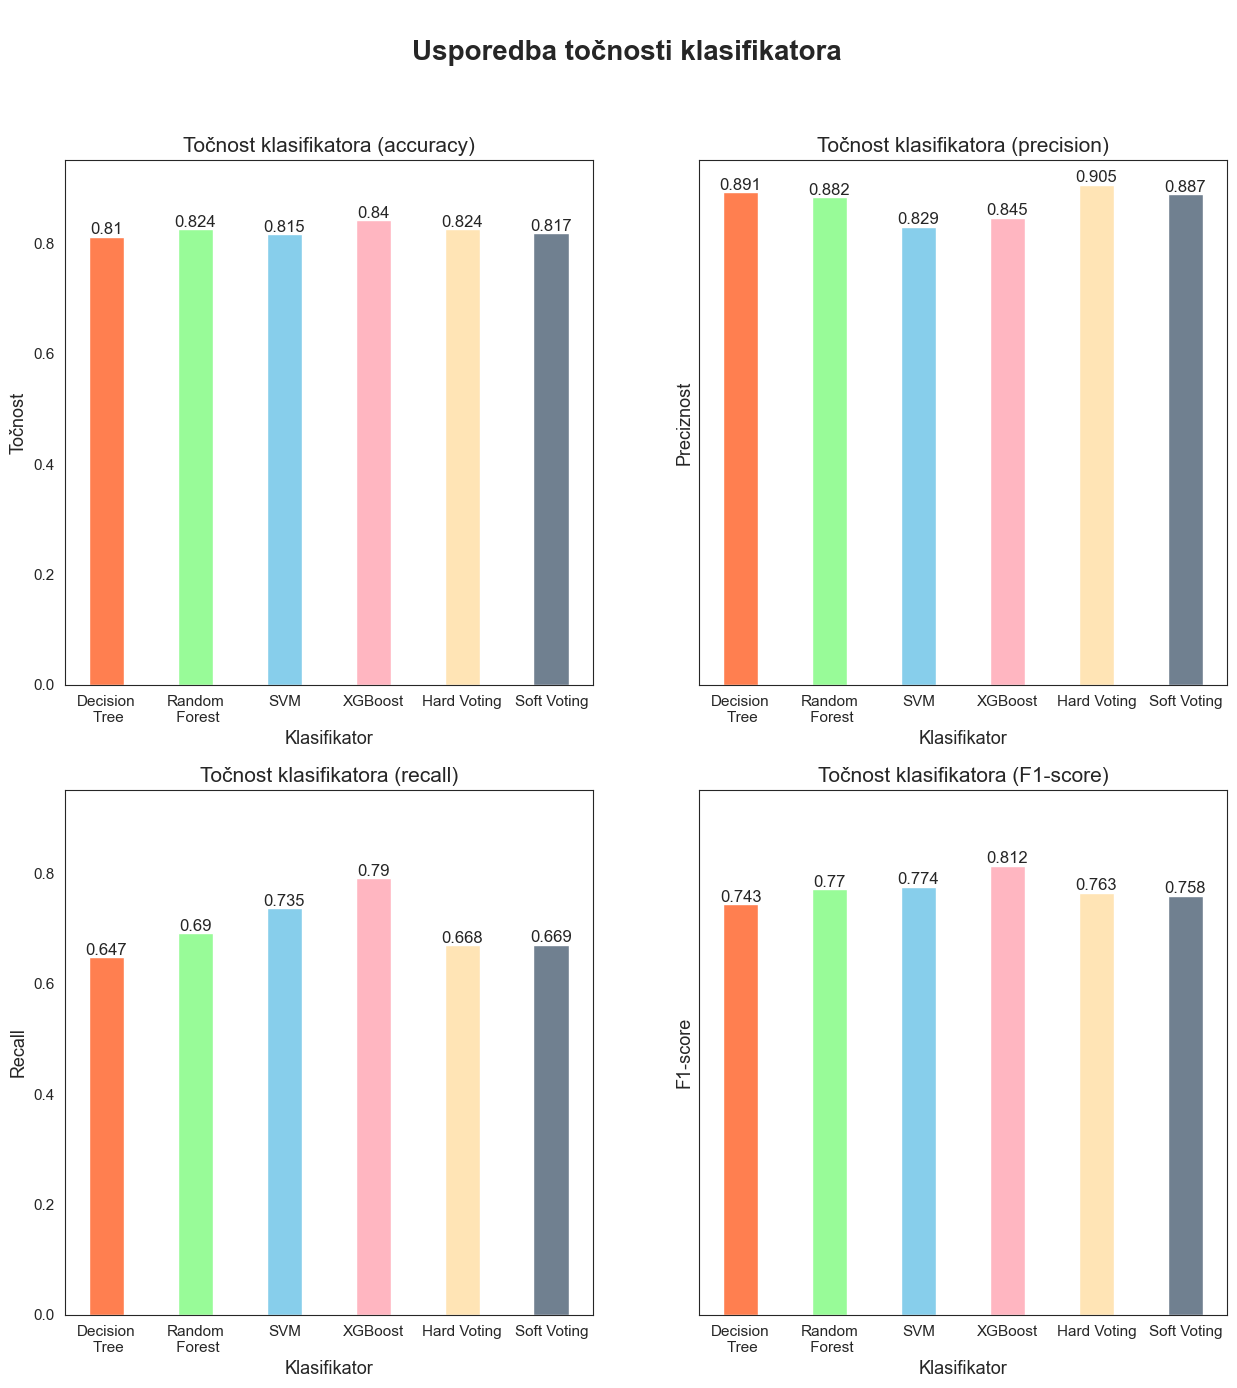

In [51]:

sns.set_style("white")
colors = ["coral","palegreen","skyblue","lightpink","moccasin","slategray"]
accuracy = {'Decision\n Tree':round(average_accuracy_dt,3), 'Random\n Forest':round(average_accuracy_rf,3), 'SVM':round(average_accuracy_svm,3),'XGBoost':round(average_accuracy_xgb,3), 'Hard Voting':round(average_accuracy_vh,3),'Soft Voting':round(average_accuracy_vs,3)}
classifiers = list(accuracy.keys())

accuracies  = list(accuracy.values())

precision = {'Decision\n Tree':round(average_precision_dt,3), 'Random\n Forest':round(average_precision_rf,3), 'SVM':round(average_precision_svm,3),'XGBoost':round(average_precision_xgb,3), 'Hard Voting':round(average_precision_vh,3),'Soft Voting':round(average_precision_vs,3)}
precisions  = list(precision.values())

recall = {'Decision\n Tree':round(average_recall_dt,3), 'Random\n Forest':round(average_recall_rf,3), 'SVM':round(average_recall_svm,3),'XGBoost':round(average_recall_xgb,3), 'Hard Voting':round(average_recall_vh,3),'Soft Voting':round(average_recall_vs,3)}
recalls  = list(recall.values())

f1dict = {'Decision\n Tree':round(average_f1_dt,3), 'Random\n Forest':round(average_f1_rf,3), 'SVM':round(average_f1_svm,3),'XGBoost':round(average_f1_xgb,3), 'Hard Voting':round(average_f1_vh,3), 'Soft Voting':round(average_f1_vs,3)}
f1scores  = list(f1dict.values())


fig, axes = plt.subplots(2,2, sharey = True, figsize = (15, 15))

fig.suptitle("\nUsporedba točnosti klasifikatora",weight = "bold",fontsize = 20)


bars = axes[0,0].bar(classifiers, accuracies, color = colors,width = 0.4)
axes[0,0].bar_label(bars,size = 12)
axes[0,0].set_xlabel("Klasifikator")
axes[0,0].set_ylabel("Točnost")
axes[0,0].set_title("Točnost klasifikatora (accuracy)")
axes[0,0].title.set_fontsize(15)
for item in ( [] + axes[0,0].get_xticklabels() + axes[0,0].get_yticklabels()):
    item.set_fontsize(11)
axes[0,0].xaxis.label.set_fontsize(13) 
axes[0,0].yaxis.label.set_fontsize(13)

bars = axes[0,1].bar(classifiers, precisions, color = colors,width = 0.4)
axes[0,1].bar_label(bars,size = 12)
axes[0,1].set_xlabel("Klasifikator")
axes[0,1].set_ylabel("Preciznost")
axes[0,1].set_title("Točnost klasifikatora (precision)")
axes[0,1].title.set_fontsize(15)
for item in ( [] + axes[0,1].get_xticklabels() + axes[0,1].get_yticklabels()):
    item.set_fontsize(11)
axes[0,1].xaxis.label.set_fontsize(13) 
axes[0,1].yaxis.label.set_fontsize(13)

bars = axes[1,0].bar(classifiers, recalls, color = colors,width = 0.4)
axes[1,0].bar_label(bars,size = 12)
axes[1,0].set_xlabel("Klasifikator")
axes[1,0].set_ylabel("Recall")
axes[1,0].set_title("Točnost klasifikatora (recall)")
axes[1,0].title.set_fontsize(15)
for item in ( [] + axes[1,0].get_xticklabels() + axes[1,0].get_yticklabels()):
    item.set_fontsize(11)
axes[1,0].xaxis.label.set_fontsize(13) 
axes[1,0].yaxis.label.set_fontsize(13)

bars = axes[1,1].bar(classifiers, f1scores, color = colors ,width = 0.4)
axes[1,1].bar_label(bars,size = 12)
axes[1,1].set_xlabel("Klasifikator")
axes[1,1].set_ylabel("F1-score")
axes[1,1].set_title("Točnost klasifikatora (F1-score)");
axes[1,1].title.set_fontsize(15)
for item in ( [] + axes[1,1].get_xticklabels() + axes[1,1].get_yticklabels()):
    item.set_fontsize(11)
axes[1,1].xaxis.label.set_fontsize(13) 
axes[1,1].yaxis.label.set_fontsize(13)


Po *preciznosti* se ističu: stablo odluke i klasifikatori s glasanjem. Po *odzivu* (engl. recall) se pak ističe XGBoost.
*Točnost*(accuracy) nije mjera po kojoj bismo ovdje mogli izdvojiti najbolji klasifikator jer se baš po njoj radili optimizacija hiperparametara te je za sve klasifikatore slična: oko 81%. Mjera *f1-score* uzima u obzir i preciznost i odziv te bismo prema njoj mogli reći da je najbolji klasifikator za ovaj skup podataka **XGBoost**. Važno je uzeti u obzir da u slučajevima gdje je posebno važno detektirati što više pravih pozitiva (kao što je detekcija bolesti) možemo dati prednost klasifikatoru koji ima veći odziv, premda takav klasifikator ima manju preciznost (više lažnih pozitiva).

**NOVI MODELI: LOGISTIČKA REGRESIJA, K-NN, NAIVNI BAYES**

In [52]:
def performance_report(model, train, test):
    train_x1 = train.loc[:,train.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]

    test_x1 = test.loc[:,test.columns.isin(["M/F", "Age", "Educ", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]

    data_train = scaler.fit_transform(train_x1) #skaliranje značajno utječe na točnost predikcije (oko 10%)
    data_test = scaler.transform(test_x1)
    
    model.fit(data_train, train_y1)
    
    model_predictions = model.predict(data_test)

    model_accuracy = accuracy_score(test_y1, model_predictions)
    model_precision = precision_score(test_y1, model_predictions)
    model_recall = recall_score(test_y1, model_predictions)
    model_f1 = f1_score(test_y1, model_predictions)
    scores_accuracy.append(model_accuracy)
    scores_precision.append(model_precision)
    scores_recall.append(model_recall)
    scores_f1.append(model_f1)

Odlučili smo isprobati tradicionaln probabilistički model strojnog učenja: logističku regresiju. Isprobavanjem različitih faktora regularizacije dobiva se da je optimalan faktor jednak 1 što je i pretpostavljena vrijednost u *scikit-learnu*. Vrlo važnim za točnost predikcije se pokazalo skalirati značajke kako skala značajke ne bi utjecao na njenu važnost pri predikciji.

In [53]:

C = [2**i for i in range (-5,5)]
accuracy = 0
best_regularization = C[0]


for c in C:
    clf = LogisticRegression(C = c)
    #print(f" C = {c}")
    scores = cross_val_score(clf, data_t, train_Y, cv=5)
    score = scores.mean()
    if score > accuracy:
        accuracy = score
        best_regularization =  c
    #print(f"točnost: {score}")
print(f"optimalan faktor regularizacije: {best_regularization}")

optimalan faktor regularizacije: 1


In [54]:
# groups = np.array(train_df["ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):


    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    logReg = LogisticRegression(random_state=42)
    performance_report(logReg, train, test)
    

average_accuracy_lr = (np.array(scores_accuracy)).mean()
average_precision_lr = (np.array(scores_precision)).mean()
average_recall_lr = (np.array(scores_recall)).mean()
average_f1_lr = (np.array(scores_f1)).mean()

print("MODEL LOGISTIČKA REGRESIJA - 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_lr:.3f}")
print(f"Prosječna točnost (precision): {average_precision_lr:.3f}")
print(f"Prosječna točnost (recall): {average_recall_lr:.3f}")
print(f"Prosječna točnost (f1): {average_f1_lr:.3f}")

MODEL LOGISTIČKA REGRESIJA - 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.815
Prosječna točnost (precision): 0.842
Prosječna točnost (recall): 0.729
Prosječna točnost (f1): 0.775


**K-NN KLASIFIKATOR**

In [55]:
K = [3, 4, 5, 10, 15, 20, 50, 100, 250, 300]
accuracy = 0
best_k = K[0]

for k in K:
    knn_class = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_class, data_t, train_Y)
    score = scores.mean()
    # print(k, score)
    if score > accuracy:
        accuracy = score
        best_k =  k

print(f"Optimalan broj susjeda: {best_k}")

Optimalan broj susjeda: 3


In [56]:
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    knn_class = KNeighborsClassifier(n_neighbors=best_k)
    performance_report(knn_class, train, test)

average_accuracy_knn = (np.array(scores_accuracy)).mean()
average_precision_knn = (np.array(scores_precision)).mean()
average_recall_knn = (np.array(scores_recall)).mean()
average_f1_knn = (np.array(scores_f1)).mean()

print("MODEL K-NN KLASIFIKATORA - 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_knn:.3f}")
print(f"Prosječna točnost (precision): {average_precision_knn:.3f}")
print(f"Prosječna točnost (recall): {average_recall_knn:.3f}")
print(f"Prosječna točnost (f1): {average_f1_knn:.3f}")

MODEL K-NN KLASIFIKATORA - 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.705
Prosječna točnost (precision): 0.672
Prosječna točnost (recall): 0.695
Prosječna točnost (f1): 0.669


**NAIVNI BAYES**

In [57]:
# kod za naivni bayes

group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    NB_class = GaussianNB()
    performance_report(NB_class, train, test)

average_accuracy_NB = (np.array(scores_accuracy)).mean()
average_precision_NB = (np.array(scores_precision)).mean()
average_recall_NB = (np.array(scores_recall)).mean()
average_f1_NB = (np.array(scores_f1)).mean()

print("MODEL BAYESOVOG KLASIFIKATORA - 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_NB:.3f}")
print(f"Prosječna točnost (precision): {average_precision_NB:.3f}")
print(f"Prosječna točnost (recall): {average_recall_NB:.3f}")
print(f"Prosječna točnost (f1): {average_f1_NB:.3f}")

MODEL BAYESOVOG KLASIFIKATORA - 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.812
Prosječna točnost (precision): 0.857
Prosječna točnost (recall): 0.695
Prosječna točnost (f1): 0.759


**KLASIFIKATOR S GLASANJEM (engl. Voting classifier)**


Isprobali smo tvrdo i meko glasanje koristeći sve isprobane modele.

#### Hard voting

In [58]:
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

clf5 = LogisticRegression(random_state=42)
clf6 = KNeighborsClassifier(n_neighbors=best_k)
clf7 = GaussianNB()

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    hard_class = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4),
                                              ('lr', clf5), ('knn', clf6), ('nb', clf7)], voting='hard')
    performance_report(hard_class, train, test)

average_accuracy_HV = (np.array(scores_accuracy)).mean()
average_precision_HV = (np.array(scores_precision)).mean()
average_recall_HV = (np.array(scores_recall)).mean()
average_f1_HV = (np.array(scores_f1)).mean()

print("MODEL HARD VOTING KLASIFIKATORA - 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_HV:.3f}")
print(f"Prosječna točnost (precision): {average_precision_HV:.3f}")
print(f"Prosječna točnost (recall): {average_recall_HV:.3f}")
print(f"Prosječna točnost (f1): {average_f1_HV:.3f}")

MODEL HARD VOTING KLASIFIKATORA - 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.829
Prosječna točnost (precision): 0.860
Prosječna točnost (recall): 0.728
Prosječna točnost (f1): 0.784


#### Soft voting

In [59]:
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

clf5 = LogisticRegression(random_state=42)
clf6 = KNeighborsClassifier(n_neighbors=best_k)
clf7 = GaussianNB()

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["ID"].isin(groups[train_index])]
    test = train_df[train_df["ID"].isin(groups[test_index])]
    
    soft_class = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4),
                                              ('lr', clf5), ('knn', clf6), ('nb', clf7)], voting='soft')
    performance_report(soft_class, train, test)

average_accuracy_SV = (np.array(scores_accuracy)).mean()
average_precision_SV = (np.array(scores_precision)).mean()
average_recall_SV = (np.array(scores_recall)).mean()
average_f1_SV = (np.array(scores_f1)).mean()

print("MODEL SOFT VOTING KLASIFIKATORA - 10fold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_SV:.3f}")
print(f"Prosječna točnost (precision): {average_precision_SV:.3f}")
print(f"Prosječna točnost (recall): {average_recall_SV:.3f}")
print(f"Prosječna točnost (f1): {average_f1_SV:.3f}")

MODEL SOFT VOTING KLASIFIKATORA - 10fold unakrsna validacija
Prosječna točnost (accuracy): 0.831
Prosječna točnost (precision): 0.863
Prosječna točnost (recall): 0.729
Prosječna točnost (f1): 0.786


## USPOREDBA REZULTATA KLASIFIKATORA 

U nastavku su prikazane matrice konfuzije na skupu za testiranje svih isprobanih modela. Usporedili smo modele međusobno po metrikama točnosti (accuracy, recall, precision i f1-score) te se osvrnuli na originalne rezultate iz članka.

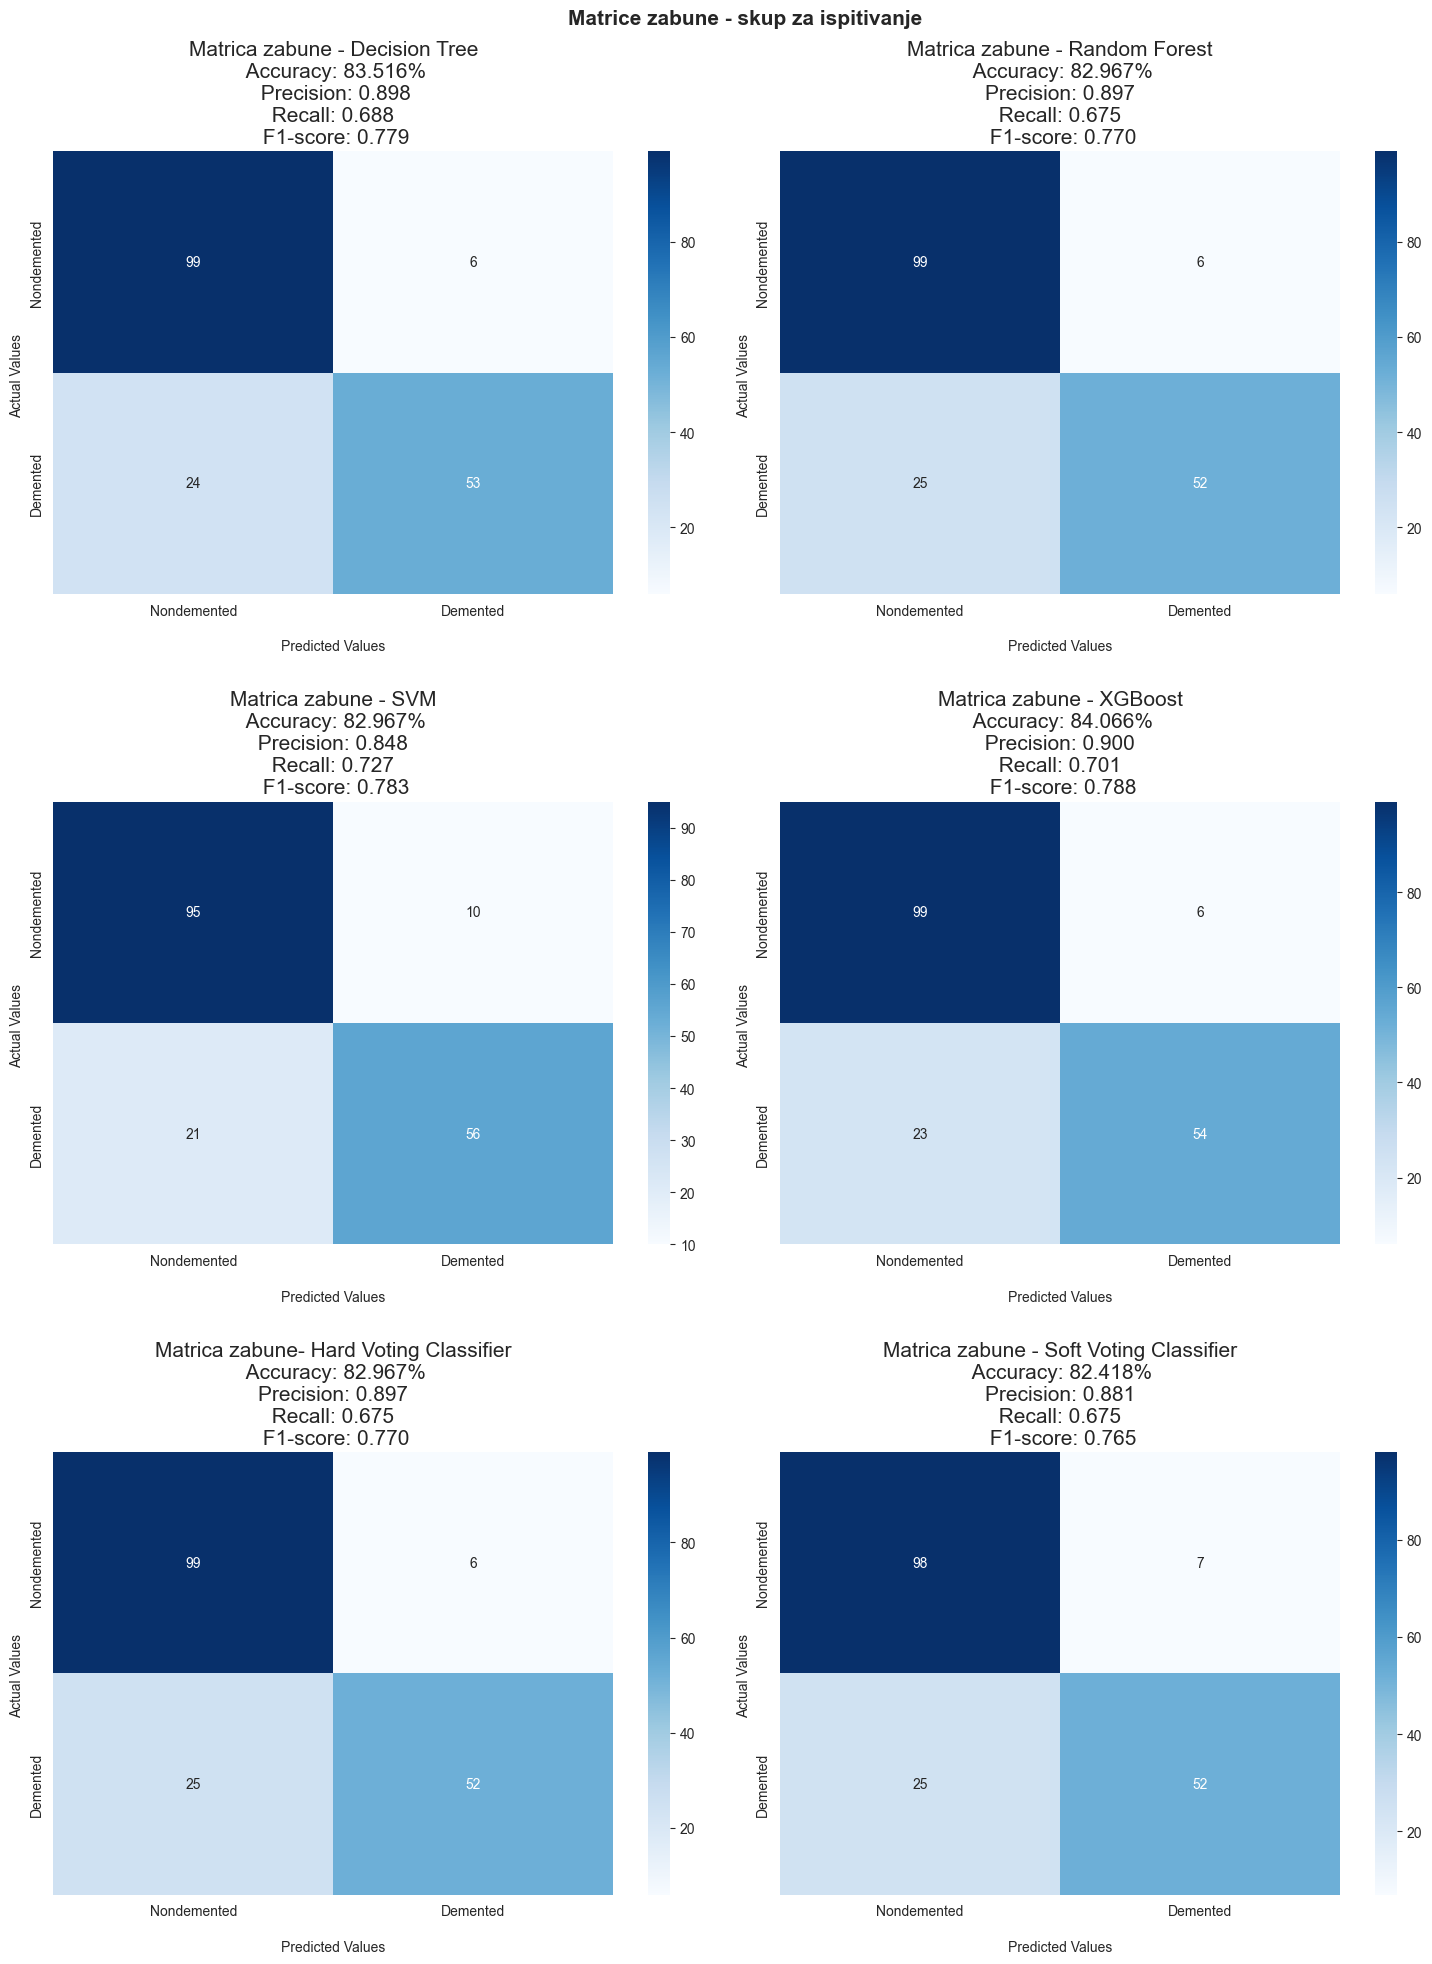

In [60]:
fig, axes = plt.subplots(3,2, figsize = (15, 20))
fig.suptitle("Matrice zabune - skup za ispitivanje",weight = "bold", fontsize = 15)

cf_matrix = confusion_matrix(test_Y, dt_predictions)
dt_accuracy = accuracy_score(test_Y,dt_predictions)*100
dt_precision= precision_score(test_Y,dt_predictions)
dt_recall = recall_score(test_Y,dt_predictions)
dt_f1 = f1_score(test_Y,dt_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[0,0])

axes[0,0].set_title(f'\nMatrica zabune - Decision Tree\n Accuracy: {dt_accuracy:.3f}%\n Precision: {dt_precision:.3f}\n Recall: {dt_recall:.3f} \n F1-score: {dt_f1:.3f}');
axes[0,0].set_xlabel('\nPredicted Values')
axes[0,0].set_ylabel('Actual Values ');
axes[0,0].title.set_fontsize(15)
axes[0,0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[0,0].yaxis.set_ticklabels(['Nondemented','Demented'])



cf_matrix = confusion_matrix(test_Y, rf_predictions)
rf_accuracy = accuracy_score(test_Y,rf_predictions)*100
rf_precision= precision_score(test_Y,rf_predictions)
rf_recall = recall_score(test_Y,rf_predictions)
rf_f1 = f1_score(test_Y,rf_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[0,1])

axes[0,1].set_title(f'\nMatrica zabune - Random Forest\n Accuracy: {rf_accuracy:.3f}%\nPrecision: {rf_precision:.3f}\n Recall: {rf_recall:.3f} \n F1-score: {rf_f1:.3f}');
axes[0,1].set_xlabel('\nPredicted Values')
axes[0,1].set_ylabel('Actual Values ');
axes[0,1].title.set_fontsize(15)
axes[0,1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[0,1].yaxis.set_ticklabels(['Nondemented','Demented'])


cf_matrix = confusion_matrix(test_Y, svm_predictions)
svm_accuracy = accuracy_score(test_Y,svm_predictions)*100
svm_precision= precision_score(test_Y,svm_predictions)
svm_recall = recall_score(test_Y,svm_predictions)
svm_f1 = f1_score(test_Y,svm_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[1,0])

axes[1,0].set_title(f'\nMatrica zabune - SVM\n Accuracy: {svm_accuracy:.3f}%\n Precision: {svm_precision:.3f} \n Recall: {svm_recall:.3f} \n F1-score: {svm_f1:.3f}');
axes[1,0].set_xlabel('\nPredicted Values')
axes[1,0].set_ylabel('Actual Values ');
axes[1,0].title.set_fontsize(15)
axes[1,0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[1,0].yaxis.set_ticklabels(['Nondemented','Demented'])

cf_matrix = confusion_matrix(test_Y, xgb_predictions)
xgb_accuracy = accuracy_score(test_Y,xgb_predictions)*100
xgb_precision= precision_score(test_Y,xgb_predictions)
xgb_recall = recall_score(test_Y,xgb_predictions)
xgb_f1 = f1_score(test_Y,xgb_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[1,1])

axes[1,1].set_title(f'\nMatrica zabune - XGBoost\n Accuracy: {xgb_accuracy:.3f}%\n Precision: {xgb_precision:.3f} \n Recall: {xgb_recall:.3f} \n F1-score: {xgb_f1:.3f}');
axes[1,1].set_xlabel('\nPredicted Values')
axes[1,1].set_ylabel('Actual Values ');
axes[1,1].title.set_fontsize(15)
axes[1,1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[1,1].yaxis.set_ticklabels(['Nondemented','Demented'])


cf_matrix = confusion_matrix(test_Y, vc_predictions)
vh_accuracy = accuracy_score(test_Y,vc_predictions)*100
vh_precision= precision_score(test_Y,vc_predictions)
vh_recall = recall_score(test_Y,vc_predictions)
vh_f1 = f1_score(test_Y,vc_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[2,0])

axes[2,0].set_title(f'\nMatrica zabune- Hard Voting Classifier\n Accuracy: {vh_accuracy:.3f}%\nPrecision: {vh_precision:.3f}\n Recall: {vh_recall:.3f} \n F1-score: {vh_f1:.3f}');
axes[2,0].set_xlabel('\nPredicted Values')
axes[2,0].set_ylabel('Actual Values ');
axes[2,0].title.set_fontsize(15)
axes[2,0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[2,0].yaxis.set_ticklabels(['Nondemented','Demented'])

cf_matrix = confusion_matrix(test_Y, vc_s_predictions)
vs_accuracy = accuracy_score(test_Y,vc_s_predictions)*100
vs_precision= precision_score(test_Y,vc_s_predictions)
vs_recall = recall_score(test_Y,vc_s_predictions)
vs_f1 = f1_score(test_Y,vc_s_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[2,1])

axes[2,1].set_title(f'\nMatrica zabune - Soft Voting Classifier\n Accuracy: {vs_accuracy:.3f}%\nPrecision: {vs_precision:.3f}\n Recall: {vs_recall:.3f} \n F1-score: {vs_f1:.3f}');
axes[2,1].set_xlabel('\nPredicted Values')
axes[2,1].set_ylabel('Actual Values ');
axes[2,1].title.set_fontsize(15)
axes[2,1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[2,1].yaxis.set_ticklabels(['Nondemented','Demented']);

plt.tight_layout()

(0.0, 1.0, 0.0, 1.0)

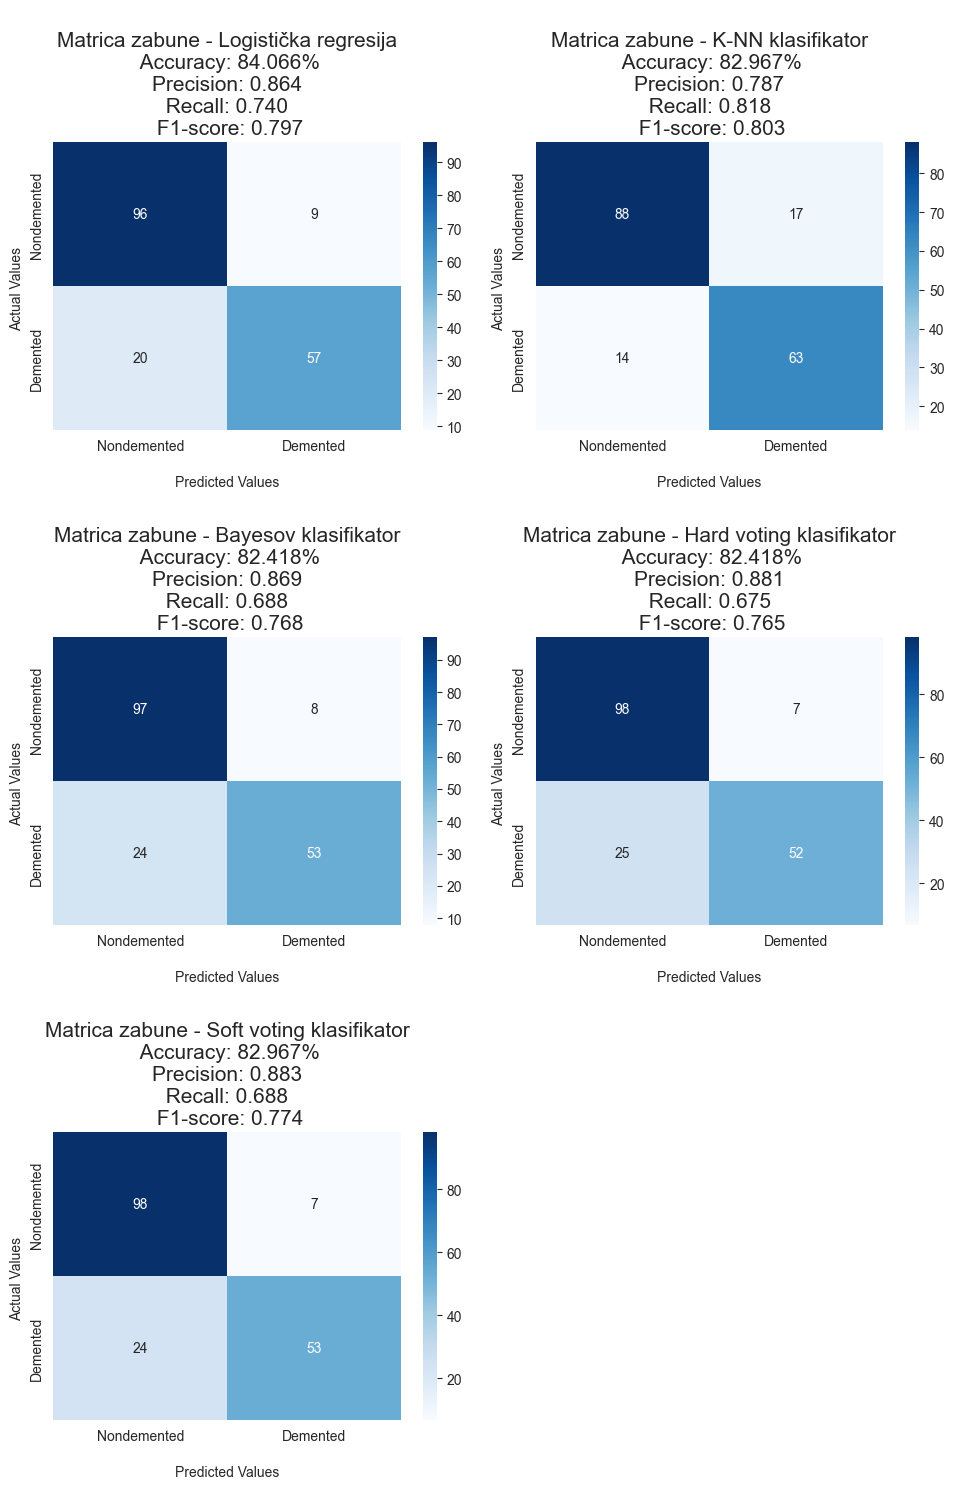

In [65]:
clfLR = LogisticRegression(random_state = 42)
clfLR = clfLR.fit(data_t, train_Y)
clfLR_predictions = clfLR.predict(test_t)

cf_matrix = confusion_matrix(test_Y, clfLR_predictions)
lr_accuracy = accuracy_score(test_Y,clfLR_predictions)*100
lr_precision= precision_score(test_Y,clfLR_predictions)
lr_recall = recall_score(test_Y,clfLR_predictions)
lr_f1 = f1_score(test_Y,clfLR_predictions)


fig, axes = plt.subplots(3, 2, figsize = (10, 15))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax = axes[0, 0])

axes[0, 0].set_title(f'\nMatrica zabune - Logistička regresija\n Accuracy: {lr_accuracy:.3f}%\nPrecision: {lr_precision:.3f}\n Recall: {lr_recall:.3f} \n F1-score: {lr_f1:.3f}');
axes[0, 0].set_xlabel('\nPredicted Values')
axes[0, 0].set_ylabel('Actual Values ');
axes[0, 0].title.set_fontsize(15)
axes[0, 0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[0, 0].yaxis.set_ticklabels(['Nondemented','Demented']);

# ===== K-NN Classifier =====

clfKNN = KNeighborsClassifier(n_neighbors=best_k)
clfKNN = clfKNN.fit(data_t, train_Y.ravel())
clfKNN_predictions = clfKNN.predict(test_t)

cf_matrix = confusion_matrix(test_Y, clfKNN_predictions)
knn_accuracy = accuracy_score(test_Y,clfKNN_predictions)*100
knn_precision= precision_score(test_Y,clfKNN_predictions)
knn_recall = recall_score(test_Y,clfKNN_predictions)
knn_f1 = f1_score(test_Y,clfKNN_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax = axes[0, 1])

axes[0, 1].set_title(f'\nMatrica zabune - K-NN klasifikator\n Accuracy: {knn_accuracy:.3f}%\nPrecision: {knn_precision:.3f}\n Recall: {knn_recall:.3f} \n F1-score: {knn_f1:.3f}');
axes[0, 1].set_xlabel('\nPredicted Values')
axes[0, 1].set_ylabel('Actual Values ');
axes[0, 1].title.set_fontsize(15)
axes[0, 1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[0, 1].yaxis.set_ticklabels(['Nondemented','Demented']);


# ===== BAYES Classifier =====

clfNB = GaussianNB()
clfNB = clfNB.fit(data_t, train_Y.ravel())
clfNB_predictions = clfNB.predict(test_t)

cf_matrix = confusion_matrix(test_Y, clfNB_predictions)
NB_accuracy = accuracy_score(test_Y,clfNB_predictions)*100
NB_precision= precision_score(test_Y,clfNB_predictions)
NB_recall = recall_score(test_Y,clfNB_predictions)
NB_f1 = f1_score(test_Y,clfNB_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax = axes[1, 0])

axes[1, 0].set_title(f'\nMatrica zabune - Bayesov klasifikator\n Accuracy: {NB_accuracy:.3f}%\nPrecision: {NB_precision:.3f}\n Recall: {NB_recall:.3f} \n F1-score: {NB_f1:.3f}');
axes[1, 0].set_xlabel('\nPredicted Values')
axes[1, 0].set_ylabel('Actual Values ');
axes[1, 0].title.set_fontsize(15)
axes[1, 0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[1, 0].yaxis.set_ticklabels(['Nondemented','Demented']);



# ===== HARD VOTING Classifier =====

clfHV = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4),
                                    ('lr', clf5), ('knn', clf6), ('nb', clf7)], voting='hard')
clfHV = clfHV.fit(data_t, train_Y.ravel())
clfHV_predictions = clfHV.predict(test_t)

cf_matrix = confusion_matrix(test_Y, clfHV_predictions)
HV_accuracy = accuracy_score(test_Y,clfHV_predictions)*100
HV_precision= precision_score(test_Y,clfHV_predictions)
HV_recall = recall_score(test_Y,clfHV_predictions)
HV_f1 = f1_score(test_Y,clfHV_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax = axes[1, 1])

axes[1, 1].set_title(f'\nMatrica zabune - Hard voting klasifikator\n Accuracy: {HV_accuracy:.3f}%\nPrecision: {HV_precision:.3f}\n Recall: {HV_recall:.3f} \n F1-score: {HV_f1:.3f}');
axes[1, 1].set_xlabel('\nPredicted Values')
axes[1, 1].set_ylabel('Actual Values ');
axes[1, 1].title.set_fontsize(15)
axes[1, 1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[1, 1].yaxis.set_ticklabels(['Nondemented','Demented']);




# ===== SOFT VOTING Classifier =====

clfSV = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4),
                                    ('lr', clf5), ('knn', clf6), ('nb', clf7)], voting='soft')
clfSV = clfSV.fit(data_t, train_Y.ravel())
clfSV_predictions = clfSV.predict(test_t)

cf_matrix = confusion_matrix(test_Y, clfSV_predictions)
SV_accuracy = accuracy_score(test_Y,clfSV_predictions)*100
SV_precision= precision_score(test_Y,clfSV_predictions)
SV_recall = recall_score(test_Y,clfSV_predictions)
SV_f1 = f1_score(test_Y,clfSV_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax = axes[2, 0])

axes[2, 0].set_title(f'\nMatrica zabune - Soft voting klasifikator\n Accuracy: {SV_accuracy:.3f}%\nPrecision: {SV_precision:.3f}\n Recall: {SV_recall:.3f} \n F1-score: {SV_f1:.3f}');
axes[2, 0].set_xlabel('\nPredicted Values')
axes[2, 0].set_ylabel('Actual Values ');
axes[2, 0].title.set_fontsize(15)
axes[2, 0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[2, 0].yaxis.set_ticklabels(['Nondemented','Demented']);

plt.tight_layout()

axes[2,1].axis('off')

## Usporedba naših rezultata s rezultatima članka ##

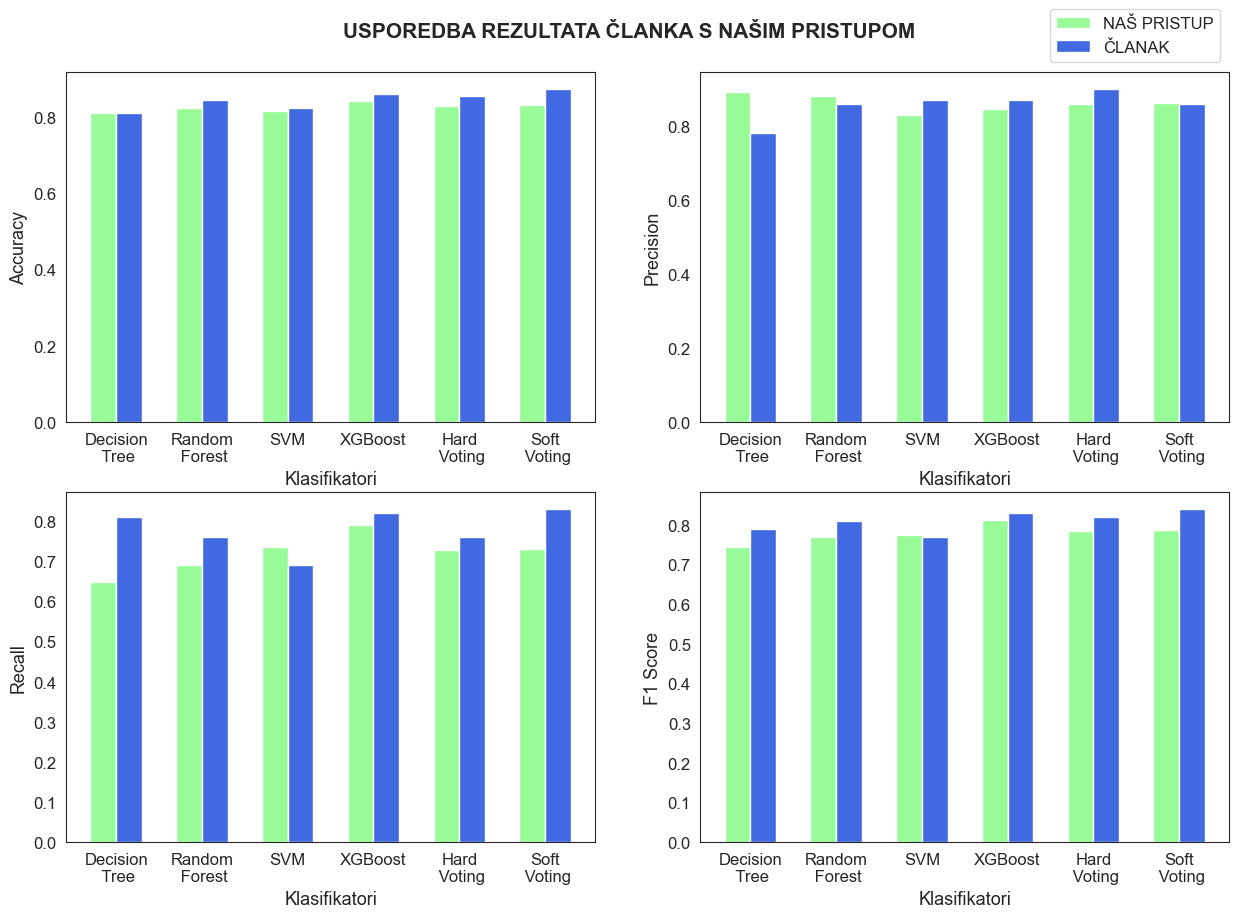

<Figure size 640x480 with 0 Axes>

In [62]:
# broj klasifikatora
N = 6

nase = (round(average_accuracy_dt,3), round(average_accuracy_rf,3), round(average_accuracy_svm,3), round(average_accuracy_xgb,3),round(average_accuracy_HV,3),round(average_accuracy_SV,3))
njihovo = (0.811, 0.843, 0.822, 0.859, 0.854, 0.873)

# pozicija na x-osi
ind = np.arange(N)

fig, axes = plt.subplots(2,2,figsize=(15,10))
plt.suptitle('USPOREDBA REZULTATA ČLANKA S NAŠIM PRISTUPOM',weight =  "bold",fontsize = 15,y=0.93)

#širina stupca
width = 0.3


axes[0,0].bar(ind, nase , width, label='NAŠ PRISTUP', color ="palegreen")
axes[0,0].bar(ind + width, njihovo, width, color='royalblue', label = "ČLANAK")

axes[0,0].set_xlabel('Klasifikatori')
axes[0,0].set_ylabel('Accuracy')


axes[0,0].set_xticks(ind + width / 2)
axes[0,0].set_xticklabels(labels = ("Decision\n Tree", "Random\n Forest", "SVM", "XGBoost", "Hard\n Voting", "Soft\n Voting"))
for item in ( [] + axes[0,0].get_xticklabels() + axes[0,0].get_yticklabels()):
    item.set_fontsize(12)
axes[0,0].xaxis.label.set_fontsize(13) 
axes[0,0].yaxis.label.set_fontsize(13)
axes[0,0].title.set_fontsize(15)
#axes[0,0].legend()


# Precision

nase = (round(average_precision_dt,3), round(average_precision_rf,3), round(average_precision_svm,3), round(average_precision_xgb,3),round(average_precision_HV,3),round(average_precision_SV,3))
njihovo = (0.78, 0.86, 0.87, 0.87, 0.9, 0.86)    

axes[0,1].bar(ind, nase , width, label='NAŠ PRISTUP', color ="palegreen")
axes[0,1].bar(ind + width, njihovo, width, color='royalblue', label = "ČLANAK")

axes[0,1].set_xlabel('Klasifikatori')
axes[0,1].set_ylabel('Precision')

axes[0,1].set_xticks(ind + width / 2)
axes[0,1].set_xticklabels(labels = ("Decision\n Tree", "Random\n Forest", "SVM", "XGBoost", "Hard\n Voting", "Soft\n Voting"))
#axes[0,1].set_xticks(ind + width / 2, ("Decision\n Tree", "Random\n Forest", "SVM", "XGBoost", "Hard Voting", "Soft Voting"), rotation=90)
for item in ( [] + axes[0,1].get_xticklabels() + axes[0,1].get_yticklabels()):
    item.set_fontsize(12)
axes[0,1].xaxis.label.set_fontsize(13) 
axes[0,1].yaxis.label.set_fontsize(13)
axes[0,1].title.set_fontsize(15)



#Recall

nase = (round(average_recall_dt,3), round(average_recall_rf,3), round(average_recall_svm,3), round(average_recall_xgb,3),round(average_recall_HV,3),round(average_recall_SV,3))
njihovo = (0.81, 0.76, 0.69, 0.82, 0.76, 0.83)

axes[1,0].bar(ind, nase , width, label='NAŠ PRISTUP', color ="palegreen")
axes[1,0].bar(ind + width, njihovo, width, color='royalblue', label = "ČLANAK")

axes[1,0].set_xlabel('Klasifikatori')
axes[1,0].set_ylabel('Recall')

axes[1,0].set_xticks(ind + width / 2)
axes[1,0].set_xticklabels(labels = ("Decision\n Tree", "Random\n Forest", "SVM", "XGBoost", "Hard\n Voting", "Soft\n Voting"))
#axes[1,0].set_xticks(ind + width / 2, ("Decision\n Tree", "Random\n Forest", "SVM", "XGBoost", "Hard Voting", "Soft Voting"))
for item in ( [] + axes[1,0].get_xticklabels() + axes[1,0].get_yticklabels()):
    item.set_fontsize(12)
axes[1,0].xaxis.label.set_fontsize(13) 
axes[1,0].yaxis.label.set_fontsize(13)
axes[1,0].title.set_fontsize(15)



# F1

nase = (round(average_f1_dt,3), round(average_f1_rf,3), round(average_f1_svm,3), round(average_f1_xgb,3),round(average_f1_HV,3),round(average_f1_SV,3))
njihovo = (0.79, 0.81, 0.77, 0.83, 0.82, 0.84) 

axes[1,1].bar(ind, nase , width, label='NAŠ PRISTUP', color ="palegreen")
axes[1,1].bar(ind + width, njihovo, width, color='royalblue', label = "ČLANAK")

axes[1,1].set_xlabel('Klasifikatori')
axes[1,1].set_ylabel('F1 Score')

axes[1,1].set_xticks(ind + width / 2)
axes[1,1].set_xticklabels(labels = ("Decision\n Tree", "Random\n Forest", "SVM", "XGBoost", "Hard\n Voting", "Soft\n Voting"))
#axes[1,1].set_xticks(ind + width / 2, ("Decision\n Tree", "Random\n Forest", "SVM", "XGBoost", "Hard Voting", "Soft Voting"), rotation=90)
for item in ( [] + axes[1,1].get_xticklabels() + axes[1,1].get_yticklabels()):
    item.set_fontsize(12)
axes[1,1].xaxis.label.set_fontsize(13) 
axes[1,1].yaxis.label.set_fontsize(13)
axes[1,1].title.set_fontsize(15)

plt.legend(bbox_to_anchor=(0.99, 2.39), borderaxespad=0.2,prop={'size': 12})
plt.show()
plt.tight_layout();

Prikazali smo rezultate dobivene replikacijom rezultata članka (približno isti rezultatima u članku) i rezultate dobivene predloženim poboljšanjima članka: **povećanje podatkovnog skupa i obraćanje pažnje na curenje podataka**.

Povećanje podatkovnog skupa je značajno doprinjelo povećanju mjera točnosti, ali zbog curenja informacija u članku su dobivene veće mjere točnosti nego kad se pazi da se u skupu za testiranje ne pojave isti pojedinci kao u skupu za treniranje. Slučajna podjela pri validaciji modela velik je propust članka jer se radi o longitudinalnoj studiji.
Naš je pristup doveo do povećanja preciznosti modela, ali smanjen je odziv. To smanjenje je relativno jer su dobivene vrijednosti u članku veće nego kad se provede pravilna podjela na skup za treniranje i testiranje.